In [ ]:
##################################### SETUP ####################################
import os
import glob
import json
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import PIL
from pathlib import Path
import time
import shutil
from datetime import datetime
from packaging import version
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
from keras import layers
from IPython.display import Image, display



DATASET_FILENAME     = "smart_pen_dataset"
SAVED_MODEL_FILENAME = "saved_model"
FMODEL_FILENAME      = "float_model.tfl"
QMODEL_FILENAME      = "quantized_model.tfl"
MODEL_FILENAME       = "smart_pen_model_data.cc"
NUM_CLASSES          = 26

!apt-get -qq update && apt-get -qq install xxd

!wget "https://drive.google.com/uc?export=download&id=1RMHHQIyAQppk32coNrwr7ngmAZ0syAbv" -O {DATASET_FILENAME}.tar.gz -q
!rm -rf {DATASET_FILENAME}
!tar xvzf {DATASET_FILENAME}.tar.gz 1>/dev/null
!rm -rf {DATASET_FILENAME}.tar.gz sample_data
!mkdir -p checkpoints

print("OK") if os.path.exists(DATASET_FILENAME) else print("Error")

OK


In [ ]:
############################### READ THE STROKES ###############################
strokes = []
for filename in glob.glob("smart_pen_dataset/*.json"):
  with open(filename, "r") as file:
    file_data = file.read()
  json_data = json.loads(file_data)
  for stroke in json_data["strokes"]:
    stroke["filename"] = filename
    strokes.append(stroke)

In [ ]:
########################## RASTERIZE STROKES FUNCTION ##########################
### Pete Warden Scripts
FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue
  
  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer



###################### RASTERIZE ALL THE STROKES AS IMAGES #####################

X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
    label_path = Path(root_folder, label)
    ensure_empty_dir(label_path)

  label_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))
    for i in range(augment_count):
      augmented_points = augment_points(points, 0.1, 0.1, 0.3)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))

  return labels


In [ ]:
############################# DIVIDE IMAGES BY USE ############################# 
### Pete Warden Script

IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

shuffled_strokes = strokes
np.random.shuffle(shuffled_strokes)

test_percentage = 10
validation_percentage = 10
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

labels_test  = save_strokes_as_images(test_strokes, "test", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
labels_val   = save_strokes_as_images(validation_strokes, "validation", IMAGE_WIDTH, IMAGE_HEIGHT, 0)
labels_train = save_strokes_as_images(train_strokes, "train", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

In [ ]:
############################### PREPARE DATASETS ###############################
validation_ds = image_dataset_from_directory(
    directory='validation',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)
).prefetch(buffer_size=32)

train_ds = image_dataset_from_directory(
    directory='train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)
).prefetch(buffer_size=32)

Found 430 files belonging to 26 classes.
Found 37840 files belonging to 26 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        1216      
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 14, 14, 16)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 32)          12832     
                                                        

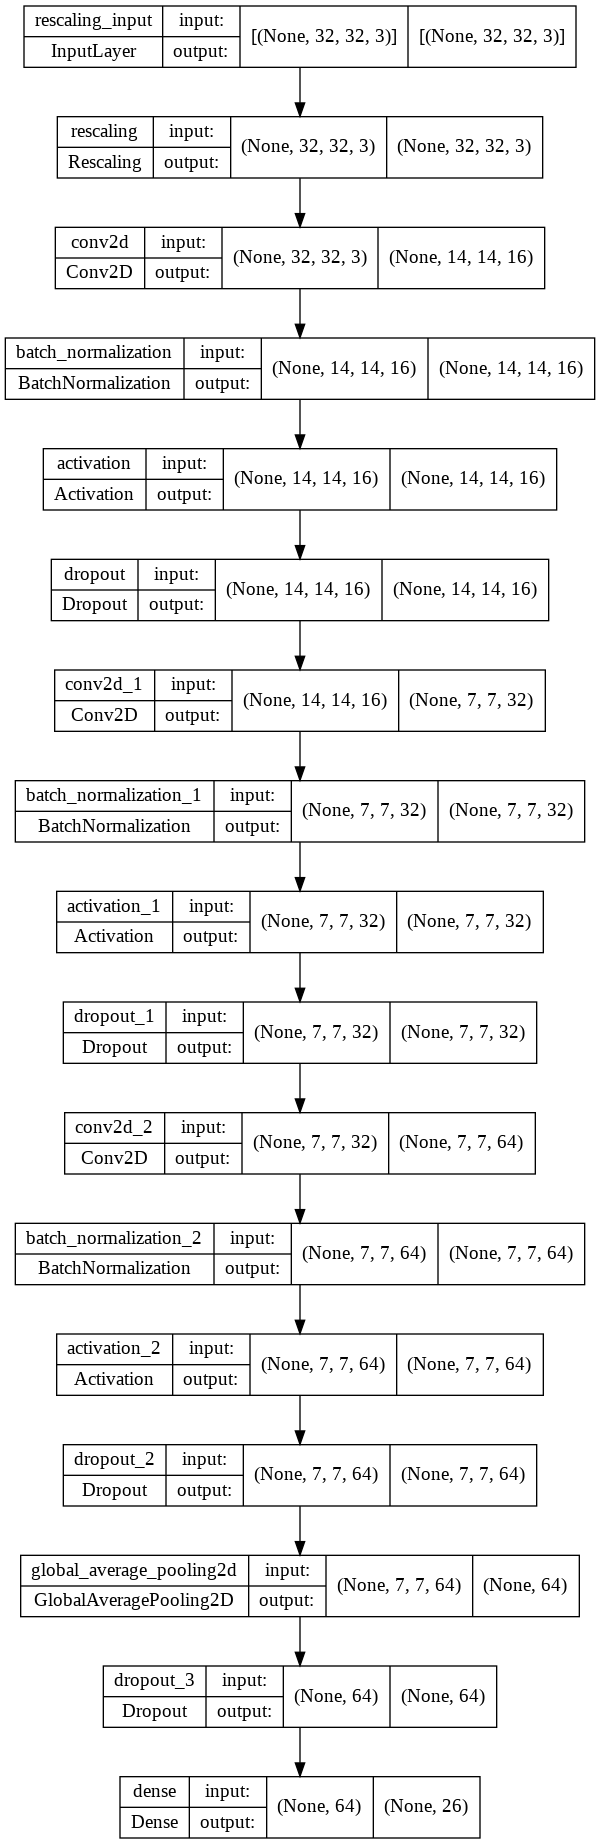

In [ ]:
############################### MAKING THE MODEL ###############################

def make_model(input_shape, num_classes):
  model = models.Sequential()

  # Rescaling
  model.add( layers.Rescaling(1.0 / 255) )
  # Block 1
  model.add( layers.Conv2D(16, 5, strides=2, input_shape=input_shape) )
  model.add( layers.BatchNormalization() )
  model.add( layers.Activation("relu") )
  model.add( layers.Dropout(0.45) )
  # Block 2
  model.add( layers.Conv2D(32, 5, strides=2, padding="same") )
  model.add( layers.BatchNormalization() )
  model.add( layers.Activation("relu") )
  model.add( layers.Dropout(0.45) )
  # Block 3
  model.add( layers.Conv2D(64, 3, strides=1, padding="same") )
  model.add( layers.BatchNormalization() )
  model.add( layers.Activation("relu") )
  model.add( layers.Dropout(0.45) )
  # Pooling + another Dropout
  model.add( layers.GlobalAveragePooling2D() )
  model.add( layers.Dropout(0.45) )
  # Softmax
  model.add( layers.Dense(num_classes, activation="softmax") )


  return model

model = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=NUM_CLASSES)
model.build(input_shape=(None, IMAGE_WIDTH, IMAGE_HEIGHT, 3))
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
############################## TRAINING THE MODEL ##############################
epochs        = 100
learning_rate = 0.00095


# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds,  
    callbacks=[tensorboard_callback]
)

# Save the model to disk
model.save(SAVED_MODEL_FILENAME)

Epoch 1/100
1183/1183 [==============================] - 28s 13ms/step - loss: 0.1611 - accuracy: 0.2226 - val_loss: 0.0892 - val_accuracy: 0.6233
Epoch 2/100
1183/1183 [==============================] - 14s 12ms/step - loss: 0.0879 - accuracy: 0.5771 - val_loss: 0.0463 - val_accuracy: 0.9209
Epoch 3/100
1183/1183 [==============================] - 14s 12ms/step - loss: 0.0664 - accuracy: 0.7228 - val_loss: 0.0308 - val_accuracy: 0.9674
Epoch 4/100
1183/1183 [==============================] - 15s 12ms/step - loss: 0.0560 - accuracy: 0.7838 - val_loss: 0.0229 - val_accuracy: 0.9837
Epoch 5/100
1183/1183 [==============================] - 15s 12ms/step - loss: 0.0503 - accuracy: 0.8134 - val_loss: 0.0189 - val_accuracy: 0.9814
Epoch 6/100
1183/1183 [==============================] - 14s 12ms/step - loss: 0.0457 - accuracy: 0.8394 - val_loss: 0.0164 - val_accuracy: 0.9814
Epoch 7/100
1183/1183 [==============================] - 14s 12ms/step - loss: 0.0431 - accuracy: 0.8494 - val_loss: 0

In [ ]:
############################## MAKING QUANT MODEL ##############################
### Pete Warden Script
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FILENAME)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(FMODEL_FILENAME, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for filename in glob.glob("test/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis for images, labels in train_ds.take(1):
    yield([img_array])

# Set Optimize flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(QMODEL_FILENAME, "wb").write(model_tflite)

41136

In [ ]:
################################# TEST THE MODELS ##############################
index_to_label = ["0", "1", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "2", "20", "21", "22", "23", "24", "25", "3", "4", "5", "6", "7", "8", "9"]

def test_modelTF(model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array).flatten()
  predicted_label_index = np.argmax(predictions)
  predicted_score = predictions[predicted_label_index]
  return (index_to_label[predicted_label_index], predicted_score)

def test_modelTFL(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])
  
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)
  
  predicted_label_index = np.argmax(pred)
  predicted_score = pred[predicted_label_index]
  return ( index_to_label[predicted_label_index], predicted_score)

image_to_test = ""
for i in range(0,NUM_CLASSES):
  image_to_test = "test/" + str(i) + "/0.png"
  print(i,":")
  print( test_modelTF (model,                 image_to_test) )
  print( test_modelTFL(model_no_quant_tflite, image_to_test) )
  print( test_modelTFL(model_tflite,          image_to_test), "\n")

0 :
('0', 1.0)
('0', 1.0)
('0', 0.99609375) 

1 :
('1', 1.0)
('1', 1.0)
('1', 0.99609375) 

2 :
('2', 0.9999938)
('2', 0.9999938)
('2', 0.99609375) 

3 :
('3', 0.9999962)
('3', 0.9999962)
('3', 0.99609375) 

4 :
('4', 0.9961205)
('4', 0.9961205)
('4', 0.99609375) 

5 :
('5', 0.99999845)
('5', 0.99999857)
('5', 0.99609375) 

6 :
('6', 0.977155)
('6', 0.977155)
('6', 0.9765625) 

7 :
('7', 0.99970055)
('7', 0.99970055)
('7', 0.99609375) 

8 :
('8', 0.9924426)
('8', 0.9924426)
('8', 0.9921875) 

9 :
('9', 0.9999591)
('9', 0.9999591)
('9', 0.99609375) 

10 :
('10', 0.9923934)
('10', 0.9923934)
('10', 0.9921875) 

11 :
('11', 0.9976043)
('11', 0.9976043)
('11', 0.99609375) 

12 :
('12', 0.99999833)
('12', 0.99999833)
('12', 0.99609375) 

13 :
('13', 0.9999746)
('13', 0.9999747)
('13', 0.99609375) 

14 :
('14', 1.0)
('14', 1.0)
('14', 0.99609375) 

15 :
('15', 0.99992967)
('15', 0.99992955)
('15', 0.99609375) 

16 :
('16', 0.9999999)
('16', 0.9999999)
('16', 0.99609375) 

17 :
('17', 0.99999

In [ ]:
################################## COMPARE MODELS ##############################
### Pete Warden Script
def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size

# Calculate size
size_tf = get_dir_size(SAVED_MODEL_FILENAME)
size_no_quant_tflite = os.path.getsize(FMODEL_FILENAME)
size_tflite = os.path.getsize(QMODEL_FILENAME)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


,Size,
Model,,
TensorFlow,756021 bytes,
TensorFlow Lite,140300 bytes,(reduced by 615721 bytes)
TensorFlow Lite Quantized,41136 bytes,(reduced by 99164 bytes)


In [ ]:
############################# PRINT labels[] FOR SKETCH ########################
labels = sorted( labels_train.union(labels_val, labels_test) )
num_labels = len(labels)

ordered_labels = "{"
for i in range(0, num_labels):
  ordered_labels += "\"" + str(labels[i]) + ("\", " if i!=num_labels-1 else "\"")
ordered_labels += "}"

print("#labels :", num_labels, "\nlabels[]:", ordered_labels)

#labels : 26 
labels[]: {"0", "1", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "2", "20", "21", "22", "23", "24", "25", "3", "4", "5", "6", "7", "8", "9"}


In [ ]:
6 ################################ MODEL TO C FORMAT ###########################
# Model to c/c++ format and Set model names
!xxd -i {QMODEL_FILENAME} > {MODEL_FILENAME}
REPLACE_TEXT = QMODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/smart_pen_model_data/g' {MODEL_FILENAME}


# My c++ header
!echo "/* =================== smart_pen_model_data.cpp ==================="
!echo "    Sketch for DeepPen"
!echo "    By Antonio Priego Raya"
!echo "    Code created for the SmartPen project:"
!echo "    https://github.com/AntonioPriego/DeepPen"
!echo ""
!echo "================================================================== */"
!echo ""
!cat {MODEL_FILENAME}

/* =================== smart_pen_model_data.cpp ===================
    Sketch for DeepPen
    By Antonio Priego Raya
    Code created for the SmartPen project:
    https://github.com/AntonioPriego/DeepPen

================================================================== */

unsigned char smart_pen_model_data[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00,
  0x14, 0x00, 0x00, 0x00, 0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00, 0x28, 0x00, 0x00, 0x00,
  0x4c, 0x01, 0x00, 0x00, 0x28, 0x00, 0x00, 0x00, 0xf4, 0x00, 0x00, 0x00,
  0x6c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x38, 0x07, 0x00, 0x00,
  0xb4, 0x03, 0x00, 0x00, 0xd0, 0x02, 0x00, 0x00, 0x14, 0x02, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x48, 0x01, 0x00, 0x00, 0x12, 0x00, 0x00, 0x00,
  0x4c, 0xa0, 0x00, 0x00, 0x48, 0xa0, 0x00, 0x00, 0x0c, 0x9f, 0x00, 0x00,
  0xb0, 0x98, 0

In [ ]:
!tensorboard dev upload \
  --logdir logs \
  --name "Sample op-level graph" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO
